In [1]:
pip install pydicom

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from PIL import Image
from PIL import ImageTk
from glob import glob
import re
import os

In [3]:
## Read-in datasets
annotations = pd.read_csv(r'C:\Users\jssuz\OneDrive\Desktop\grad_school_files\capstone\adjusted_bounding_boxes_labeled.csv')

In [7]:
photo_count = annotations['Photometric Interpretation'].value_counts()

# Display the unique counts
print(photo_count)

MONOCHROME2    618
MONOCHROME1    104
Name: Photometric Interpretation, dtype: int64


In [4]:
monochrome1 = annotations[annotations['Photometric Interpretation'] == "MONOCHROME1"]
monochrome2 = annotations[annotations['Photometric Interpretation'] == "MONOCHROME2"]

print(monochrome1.shape)
print(monochrome2.shape)

(104, 15)
(618, 15)


In [5]:
# Import All Images
import glob
image_path_list = glob.glob(r"C:\Users\jssuz\OneDrive\Desktop\grad_school_files\capstone\Dataset_B_Full\Images\**\*.dicom")
image_path_list

['C:\\Users\\jssuz\\OneDrive\\Desktop\\grad_school_files\\capstone\\Dataset_B_Full\\Images\\0025a5dc99fd5c742026f0b2b030d3e9\\2ddfad7286c2b016931ceccd1e2c7bbc.dicom',
 'C:\\Users\\jssuz\\OneDrive\\Desktop\\grad_school_files\\capstone\\Dataset_B_Full\\Images\\0025a5dc99fd5c742026f0b2b030d3e9\\451562831387e2822923204cf8f0873e.dicom',
 'C:\\Users\\jssuz\\OneDrive\\Desktop\\grad_school_files\\capstone\\Dataset_B_Full\\Images\\0025a5dc99fd5c742026f0b2b030d3e9\\47c8858666bcce92bcbd57974b5ce522.dicom',
 'C:\\Users\\jssuz\\OneDrive\\Desktop\\grad_school_files\\capstone\\Dataset_B_Full\\Images\\0025a5dc99fd5c742026f0b2b030d3e9\\fcf12c2803ba8dc564bf1287c0c97d9a.dicom',
 'C:\\Users\\jssuz\\OneDrive\\Desktop\\grad_school_files\\capstone\\Dataset_B_Full\\Images\\0028fb2c7f0b3a5cb9a80cb0e1cdbb91\\16e58fc1d65fa7587247e6224ee96527.dicom',
 'C:\\Users\\jssuz\\OneDrive\\Desktop\\grad_school_files\\capstone\\Dataset_B_Full\\Images\\0028fb2c7f0b3a5cb9a80cb0e1cdbb91\\3704f91985dcbc69f6ac2803523d1ecb.dicom'

DEFINE FUNCTIONS

In [8]:
import pydicom
from PIL import Image

# No re-sizing
def get_dicom(filepath):
    # Load the DICOM file
    dicom = pydicom.dcmread(filepath)

    # Extract pixel data from the DICOM object
    pixel_data = dicom.pixel_array

    # Convert the pixel data to an image using PIL
    image = Image.fromarray(pixel_data)

    # Convert the image back to a numpy array
    original_pixel_data = np.array(image)

    # Update pixel data, Rows, and Columns
    dicom.PixelData = original_pixel_data.tobytes()
    dicom.Rows, dicom.Columns = original_pixel_data.shape

    return dicom

In [10]:
## Returns data tables with the coordinates of the bounding boxes.

def find_coordinates(image_id, anno):
    annotations_sub = anno[anno['image_id'] == image_id]

    x1, x2, y1, y2 = None, None, None, None  # Set default values
    
    coordinates_list = []

    for index, row in annotations_sub.iterrows():
        x1 = row['xmin_adj']
        y1 = row['xmax_adj']
        x2 = row['ymin_adj']
        y2 = row['ymax_adj']

        coordinates_list.append({'X1': x1, 'Y1': y1, 'X2': x2, 'Y2': y2})

    return coordinates_list

In [12]:
def extract_image_id(image_file_path):

    file_path = r"C:\Users\jssuz\OneDrive\Desktop\grad_school_files\capstone\Dataset_B_Full\Images"

    # Define a regex pattern to match the last ID before ".dicom"
    pattern = r"/(\w+)\.dicom$"

    # Use re.search to find the match in the file path
    match = re.search(pattern, file_path)

    # Extract the matched ID
    if match:
        last_id = match.group(1)
        print(last_id)
    else:
        print("No match found.")

    return match

In [14]:
import pydicom
import os
import numpy as np
import warnings

def crop_dicom(images_filepath, coordinates, folder):
    warnings.filterwarnings("ignore", category=UserWarning, module="pydicom")

    # Load DICOM file
    dicom_data = pydicom.dcmread(images_filepath)

    # Extract pixel array from DICOM
    pixel_array = dicom_data.pixel_array

    # Crop the image based on coordinates
    x1, y1, x2, y2 = coordinates
    cropped_array = pixel_array[y1:y2, x1:x2]

    # Resize the cropped array to the target size
    resized_array = np.array(Image.fromarray(cropped_array).resize((299, 299)))
    
    ## Extract the image ID alone without the preceding filepath and the ".dicom" at the end
    image_id = images_filepath.split("\\")[-1]
    image_id = image_id.split(".")[0]

    # Update DICOM attributes (optional)
    dicom_data.Rows, dicom_data.Columns = resized_array.shape
    index = images_filepath.find(".dicom")
    
    ## Need to adjust this file path to be local.
    output_path = os.path.join(folder, f"{image_id}.dicom")

    # Save the cropped DICOM file
    dicom_data.PixelData = resized_array.tobytes()
    dicom_data.save_as(output_path)

    return dicom_data

Make Dataframe, left joined on images in folder

In [19]:
## Initialize
mono1_df = []
mono2_df = []

## Loop through each image_id to append coordinates to their filepaths.
for image_path in image_path_list:
    image_id, _ = os.path.splitext(os.path.basename(image_path))

    coordinates1 = find_coordinates(image_id, monochrome1)
    coordinates2 = find_coordinates(image_id, monochrome2)

    # Update mono1_df
    if coordinates1:
        for coord_set in coordinates1:
            mono1_df.append({'ImageID': image_id, 'X1': coord_set['X1'], 'Y1': coord_set['Y1'], 'X2': coord_set['X2'], 'Y2': coord_set['Y2'], 'ImagePath': image_path})

    # Update mono2_df
    if coordinates2:
        for coord_set in coordinates2:
            mono2_df.append({'ImageID': image_id, 'X1': coord_set['X1'], 'Y1': coord_set['Y1'], 'X2': coord_set['X2'], 'Y2': coord_set['Y2'], 'ImagePath': image_path})

# Create DataFrames
mono1_df = pd.DataFrame(mono1_df)
mono2_df = pd.DataFrame(mono2_df)

In [25]:
## Narrow down to non-NA values
mono1_df = mono1_df[~mono1_df['X1'].isna()]
mono2_df = mono2_df[~mono2_df['X1'].isna()]

## Check to see if the conversions worked.
print("Number of coordinates isolated for monochrome1:", len(mono1_df))
print("Number of coordinates isolated for monochrome2:",len(mono2_df))
print("Number of total monochrome1 coordinates", len(mono1_df) + len(mono2_df))
print("Number of original monochrome1 images", len(monochrome1))
print("Number of original monochrome2 images", len(monochrome2))
print("Number of total original images", len(monochrome1) + len(monochrome2))
print("Number of lost images", len(monochrome1) + len(monochrome2) - len(mono1_df) - len(mono2_df))

Number of coordinates isolated for monochrome1: 104
Number of coordinates isolated for monochrome2: 618
Number of total monochrome1 coordinates 722
Number of original monochrome1 images 104
Number of original monochrome2 images 618
Number of total original images 722
Number of lost images 0


In [26]:
mono1_df

,ImageID,X1,Y1,X2,Y2,ImagePath
0,0e31855d02eadf8670ffaeeaeddbf229,317.0,616.0,1509.0,1808.0,C:\Users\jssuz\OneDrive\Desktop\grad_school_fi...
1,a67700794287a21aea3695ccab16311f,576.0,875.0,1150.0,1449.0,C:\Users\jssuz\OneDrive\Desktop\grad_school_fi...
2,b7ba81b370fea9ed54efd7b07e813548,1613.0,1935.0,480.0,802.0,C:\Users\jssuz\OneDrive\Desktop\grad_school_fi...
3,f7cdf7b22955e66d34cc1efccdab5fbf,1498.0,1814.0,1459.0,1775.0,C:\Users\jssuz\OneDrive\Desktop\grad_school_fi...
4,aef8595fed1885ce9cb1644ba5d88f6f,1550.0,1849.0,1030.0,1329.0,C:\Users\jssuz\OneDrive\Desktop\grad_school_fi...
...,...,...,...,...,...,...
99,9542fd8c2f9230690935e659b491c6de,1526.0,1825.0,1055.0,1354.0,C:\Users\jssuz\OneDrive\Desktop\grad_school_fi...
100,9542fd8c2f9230690935e659b491c6de,1053.0,1413.0,1090.0,1450.0,C:\Users\jssuz\OneDrive\Desktop\grad_school_fi...
101,626d9144ab105af67e6ab1b00397531a,599.0,921.0,838.0,1160.0,C:\Users\jssuz\OneDrive\Desktop\grad_school_fi...
102,3d16da0351cc69f905bf4331bf8a2dca,97.0,396.0,1756.0,2055.0,C:\Users\jssuz\OneDrive\Desktop\grad_school_fi...


In [50]:
## Due to duplicates, we are splitting up these datasets, then outputting the images into different folders.
## Keep = 'first' takes the first entry of a duplicate pair. 
## Keep = 'last' takes the final entry of a duplicate pair.
## The idea is that we output both ends of a duplicate pair into separate folders to avoid "clash" in filenames. 

duplicates_column1 = mono1_df[mono1_df.duplicated('ImageID', keep=False)]

# Create two separate DataFrames
mono1_df1 = duplicates_column1[duplicates_column1.duplicated('ImageID', keep='first')]
mono1_df2 = duplicates_column1[duplicates_column1.duplicated('ImageID', keep='last')]

print("Monochrome1 Duplicates:", len(mono1_df1))

Monochrome1 Duplicates: 8


In [51]:
## Due to duplicates, we are splitting up these datasets, then outputting the images into different folders.
duplicates_column2 = mono2_df[mono2_df.duplicated('ImageID', keep=False)]

# Create two separate DataFrames
mono2_df1 = duplicates_column2[duplicates_column2.duplicated('ImageID', keep='first')]
mono2_df2 = duplicates_column2[duplicates_column2.duplicated('ImageID', keep='last')]

print("Monochrome2 Duplicates:", len(mono2_df1))
print("Total number of duplicates caught:", len(mono1_df1) + len(mono2_df1))

Monochrome2 Duplicates: 41
Total number of duplicates caught: 49


In [52]:
## Remove all duplicate IDs from both of the mono_dfs
mono1_unique = mono1_df[~mono1_df['ImageID'].isin(mono1_df1['ImageID'])]
mono2_unique = mono2_df[~mono2_df['ImageID'].isin(mono2_df1['ImageID'])]

In [53]:
## Appears to have worked. 
print('monochrome1 unique values:', len(mono1_unique))
print('monochrome2 unique values:', len(mono2_unique))
print('original monochrome1 values:', len(mono1_df))
print('original monochrome2 values:', len(mono2_df))

monochrome1 unique values: 88
monochrome2 unique values: 538
original monochrome1 values: 104
original monochrome2 values: 618


<h1> Export cropped dicom images

In [56]:
mono1_dir1 = r"C:\Users\jssuz\OneDrive\Desktop\grad_school_files\capstone\Dataset_B_Full\output_cropped_monochrome1\unique_ids"
mono1_dir2 = r"C:\Users\jssuz\OneDrive\Desktop\grad_school_files\capstone\Dataset_B_Full\output_cropped_monochrome1\duplicate_half1"
mono1_dir3 = r"C:\Users\jssuz\OneDrive\Desktop\grad_school_files\capstone\Dataset_B_Full\output_cropped_monochrome1\duplicate_half2"

## Three loops that go through each of the rows in each data set and output them into three folders
## mono1_dir1 includes IDs with only 1 bounding box associated with it.
## mono1_dir2 includes IDs with more than two bounding boxes. "duplicate_half1" is the first of these bounding boxes
## mono1_dir3 includes the second bounding box of duplicate IDs.

for i, row in mono1_unique.iterrows():

    if pd.notna(row['X1']):
        orig1_dicom = get_dicom(image_path_list[i])
        cropped1_dicom1 = crop_dicom(row['ImagePath'], (int(row['X1']), int(row['X2']), int(row['Y1']), int(row['Y2'])), mono1_dir1)
        
for i, row in mono1_df1.iterrows():

    if pd.notna(row['X1']):
        orig1_dicom = get_dicom(image_path_list[i])
        cropped1_dicom2 = crop_dicom(row['ImagePath'], (int(row['X1']), int(row['X2']), int(row['Y1']), int(row['Y2'])), mono1_dir2)
        
for i, row in mono1_df2.iterrows():

    if pd.notna(row['X1']):
        orig1_dicom = get_dicom(image_path_list[i])
        cropped1_dicom3 = crop_dicom(row['ImagePath'], (int(row['X1']), int(row['X2']), int(row['Y1']), int(row['Y2'])), mono1_dir3)

In [58]:
## Create a separate function to convert the monochrome2 values to monochrome1 by inverting the arrays.
## Strangely, the monochromatic values of these arrays are swapped when they should be the same,
## Since photometric interpretation should display the same array of pixels but in a different way.

def mono2_conversion(images_filepath, coordinates, folder):
    warnings.filterwarnings("ignore", category=UserWarning, module="pydicom")

    # Load DICOM file
    dicom_data = pydicom.dcmread(images_filepath)

    # Extract pixel array from DICOM
    pixel_array = dicom_data.pixel_array
    
    ## Invert entire scan before zooming in on the coordinates.
    inverted_array = np.amax(pixel_array) - pixel_array
    
    # Ensure that the inverted values are within the valid range for unsigned integers
    inverted_array = np.clip(inverted_array, 0, np.iinfo(pixel_array.dtype).max)
    
    # Crop the image based on coordinates
    x1, y1, x2, y2 = coordinates
    cropped_array = inverted_array[y1:y2, x1:x2]

    # Resize the cropped array to the target size
    resized_array = np.array(Image.fromarray(cropped_array).resize((299, 299)))
    
    # Update DICOM attributes (optional)
    dicom_data.Rows, dicom_data.Columns = resized_array.shape

    # Convert the inverted array to bytes before saving
    inverted_bytes = resized_array.astype(np.uint16).tobytes()

    # Update PixelData in DICOM object
    dicom_data.PixelData = inverted_bytes

    # Adjust the output file path
    image_id = os.path.basename(images_filepath).split(".")[0]
    output_path = os.path.join(folder, f"{image_id}.dicom")

    # Save the modified DICOM file
    dicom_data.save_as(output_path)

    return dicom_data

In [55]:
mono2_dir1 = r"C:\Users\jssuz\OneDrive\Desktop\grad_school_files\capstone\Dataset_B_Full\output_cropped_converted_monochrome2\unique_ids"
mono2_dir2 = r"C:\Users\jssuz\OneDrive\Desktop\grad_school_files\capstone\Dataset_B_Full\output_cropped_converted_monochrome2\duplicate_half1"
mono2_dir3 = r"C:\Users\jssuz\OneDrive\Desktop\grad_school_files\capstone\Dataset_B_Full\output_cropped_converted_monochrome2\duplicate_half2"

# converted_mono2_dir = r"C:\Users\jssuz\OneDrive\Desktop\grad_school_files\capstone\Dataset_B_Full\output_cropped_converted_monochrome2"

for i, row in mono2_unique.iterrows():

    if pd.notna(row['X1']):

        orig2_dicom = get_dicom(image_path_list[i])
        resized2_dicom = resize_dicom(image_path_list[i], (299,299))
        cropped2_dicom = mono2_conversion(row['ImagePath'], (int(row['X1']), int(row['X2']), int(row['Y1']), int(row['Y2'])), mono2_dir1)
        
        
for i, row in mono2_df1.iterrows():

    if pd.notna(row['X1']):

        orig2_dicom = get_dicom(image_path_list[i])
        resized2_dicom = resize_dicom(image_path_list[i], (299,299))
        cropped2_dicom = mono2_conversion(row['ImagePath'], (int(row['X1']), int(row['X2']), int(row['Y1']), int(row['Y2'])), mono2_dir2)
        
        
for i, row in mono2_df2.iterrows():

    if pd.notna(row['X1']):

        orig2_dicom = get_dicom(image_path_list[i])
        resized2_dicom = resize_dicom(image_path_list[i], (299,299))
        cropped2_dicom = mono2_conversion(row['ImagePath'], (int(row['X1']), int(row['X2']), int(row['Y1']), int(row['Y2'])), mono2_dir3)

NameError: name 'mono2_conversion' is not defined

Photometric Interpretation: MONOCHROME1


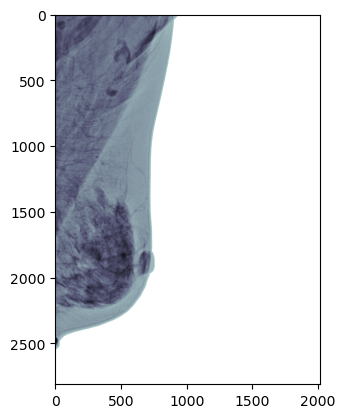

In [193]:
plt.imshow(orig1_dicom.pixel_array, cmap=plt.cm.bone)
# Access and print the Photometric Interpretation
print("Photometric Interpretation:", orig1_dicom.PhotometricInterpretation)

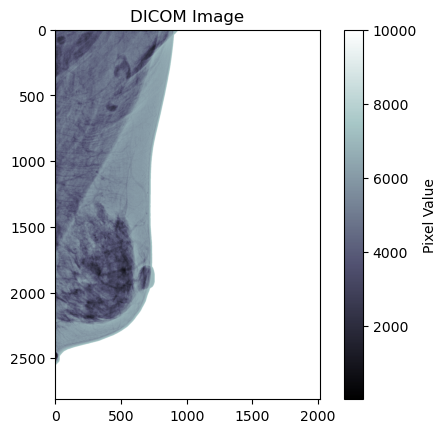

Photometric Interpretation: MONOCHROME1


In [191]:
plt.imshow(orig1_dicom.pixel_array, cmap=plt.cm.bone)
plt.title("DICOM Image")
plt.colorbar(label="Pixel Value")
plt.show()

# Access and print the Photometric Interpretation
print("Photometric Interpretation:", orig1_dicom.PhotometricInterpretation)

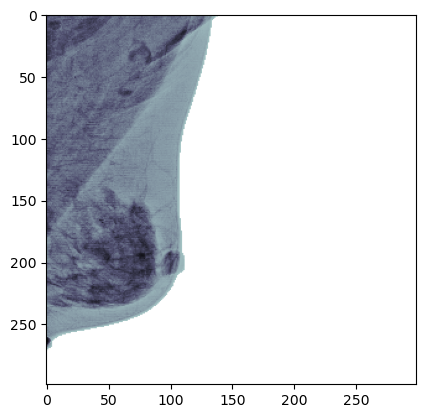

In [128]:
plt.imshow(resized1_dicom.pixel_array, cmap=plt.cm.bone)

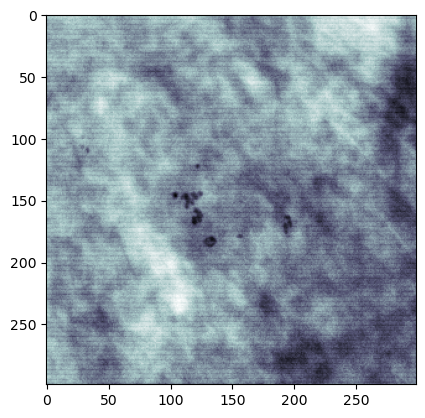

In [129]:
plt.imshow(cropped1_dicom.pixel_array, cmap=plt.cm.bone)

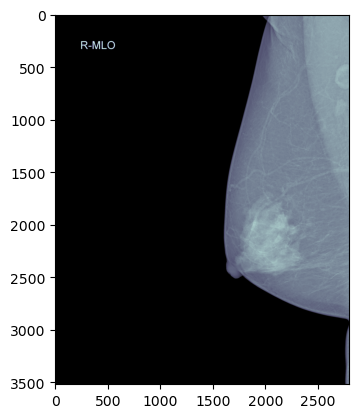

In [130]:
plt.imshow(orig2_dicom.pixel_array, cmap=plt.cm.bone)

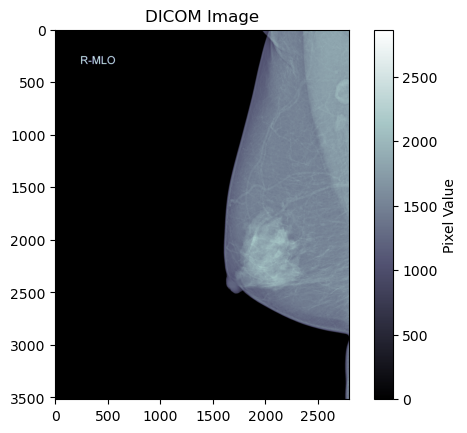

Photometric Interpretation: MONOCHROME2


In [188]:
plt.imshow(orig2_dicom.pixel_array, cmap=plt.cm.bone)
plt.title("DICOM Image")
plt.colorbar(label="Pixel Value")
plt.show()

# Access and print the Photometric Interpretation
print("Photometric Interpretation:", resized2_dicom.PhotometricInterpretation)

In [176]:
## Bottom Left Hand Corner

# Set printing options to display the full array
np.set_printoptions(threshold=np.inf)

## The values are indeed reversed when displayed.
print(orig1_dicom.pixel_array[-10:, :10])
print(orig2_dicom.pixel_array[-10:, :10])

[[10000 10000 10000 10000 10000 10000 10000 10000 10000 10000]
 [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000]
 [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000]
 [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000]
 [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000]
 [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000]
 [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000]
 [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000]
 [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000]
 [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000]]
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [91]:
print("Min Pixel Value:", np.min(orig1_dicom.pixel_array))
print("Max Pixel Value:", np.max(orig1_dicom.pixel_array))
print("Min Pixel Value:", np.min(resized1_dicom.pixel_array))
print("Max Pixel Value:", np.max(resized1_dicom.pixel_array))

Min Pixel Value: 30
Max Pixel Value: 10000
Min Pixel Value: 99
Max Pixel Value: 10000


In [102]:
## Top right hand corner:

print(orig1_dicom.pixel_array[:100, -100:])


[[10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000]
 [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 100

In [101]:
## Bottom Left Hand Corner

# Set printing options to display the full array
np.set_printoptions(threshold=np.inf)
print(resized1_dicom.pixel_array[-100:, -100:])

[[10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000]
 [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 100

In [98]:
print(orig1_dicom.pixel_array[-100:, -100:])

[[10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000]
 [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
  10000 100

In [99]:
print(resized1_dicom.pixel_array[:100, :100])

[[3227 3210 2813 3388 3515 3311 3861 3483 4265 3808 3938 3283 3494 2830
  3490 3430 3871 3825 4425 3875 3709 3705 3705 4029 4019 4120 5010 4720
  4749 4533 4939 4061 4258 4482 4476 3811 4081 3952 3875 4040 3765 3241
  3462 3994 3769 4137 4671 4047 4220 4141 3638 3172 3276 3328 4008 4559
  4350 3984 4231 4533 4203 4123 4141 3772 3910 4746 4622 4632 4395 4794
  4533 4310 3970 3765 4241 4244 4282 3941 3889 4615 3765 4241 3596 4536
  4412 4141 3980 3363 3695 4001 3311 3575 3346 2908 3325 3991 4566 4762
  4908 5124]
 [3106 2891 3688 3934 3941 3529 3836 4439 4549 4179 3589 4047 4141 4244
  3730 3487 3892 3727 4057 3787 3652 3730 4289 4835 4008 4459 5151 5115
  4589 3776 4582 4612 4268 4323 4401 3645 4071 3811 3469 3231 3536 3199
  3265 3437 3561 3984 3987 3603 3642 3297 4050 3642 3899 4241 4296 4807
  5058 4509 4771 4248 4001 4546 4350 4408 4029 5085 4973 4681 4651 4268
  4134 4425 4625 4516 4248 4364 4193 3321 4368 4651 4047 4381 4569 4784
  4408 4749 4255 4008 3970 4154 4391 4350 4539 4165

In [122]:
# print(orig2_dicom.pixel_array[:100, :100])

Photometric Interpretation: MONOCHROME2


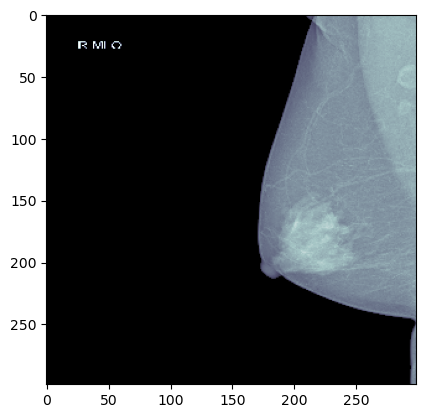

In [187]:
plt.imshow(resized2_dicom.pixel_array, cmap=plt.cm.bone)

# Access and print the Photometric Interpretation
print("Photometric Interpretation:", resized2_dicom.PhotometricInterpretation)

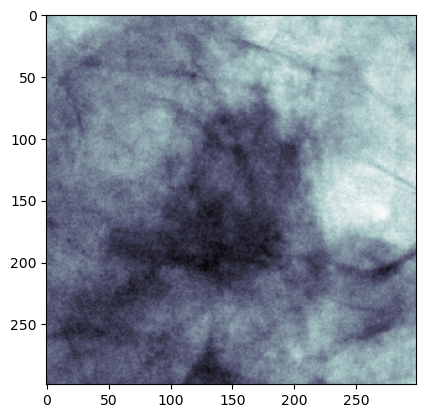

In [49]:
plt.imshow(cropped2_dicom.pixel_array, cmap=plt.cm.bone)

In [49]:
## Playground

In [81]:
image_path_list

['C:\\Users\\jssuz\\OneDrive\\Desktop\\grad_school_files\\capstone\\Dataset_B_Full\\Images\\0025a5dc99fd5c742026f0b2b030d3e9\\2ddfad7286c2b016931ceccd1e2c7bbc.dicom',
 'C:\\Users\\jssuz\\OneDrive\\Desktop\\grad_school_files\\capstone\\Dataset_B_Full\\Images\\0025a5dc99fd5c742026f0b2b030d3e9\\451562831387e2822923204cf8f0873e.dicom',
 'C:\\Users\\jssuz\\OneDrive\\Desktop\\grad_school_files\\capstone\\Dataset_B_Full\\Images\\0025a5dc99fd5c742026f0b2b030d3e9\\47c8858666bcce92bcbd57974b5ce522.dicom',
 'C:\\Users\\jssuz\\OneDrive\\Desktop\\grad_school_files\\capstone\\Dataset_B_Full\\Images\\0025a5dc99fd5c742026f0b2b030d3e9\\fcf12c2803ba8dc564bf1287c0c97d9a.dicom',
 'C:\\Users\\jssuz\\OneDrive\\Desktop\\grad_school_files\\capstone\\Dataset_B_Full\\Images\\0028fb2c7f0b3a5cb9a80cb0e1cdbb91\\16e58fc1d65fa7587247e6224ee96527.dicom',
 'C:\\Users\\jssuz\\OneDrive\\Desktop\\grad_school_files\\capstone\\Dataset_B_Full\\Images\\0028fb2c7f0b3a5cb9a80cb0e1cdbb91\\3704f91985dcbc69f6ac2803523d1ecb.dicom'

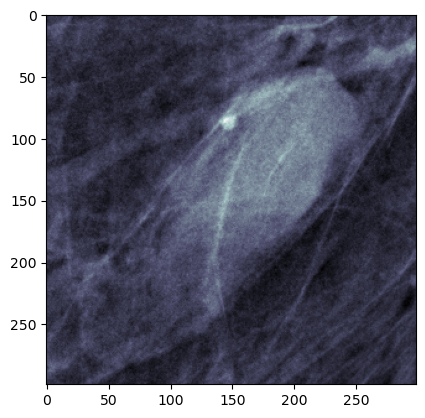

In [103]:
plt.imshow(get_dicom(r"C:\Users\jssuz\OneDrive\Desktop\grad_school_files\capstone\Dataset_B_Full\output_cropped_images\1edfbc7b48a507046042a9961755af6a.dicom").pixel_array, cmap=plt.cm.bone)

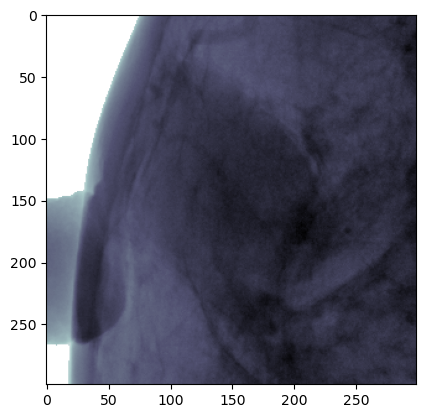

In [103]:
## Check to see if the images were successfully converted. 

plt.imshow(get_dicom(r"C:\Users\jssuz\OneDrive\Desktop\grad_school_files\capstone\Dataset_B_Full\output_cropped_converted_monochrome2\1edfbc7b48a507046042a9961755af6a.dicom").pixel_array, cmap=plt.cm.bone)

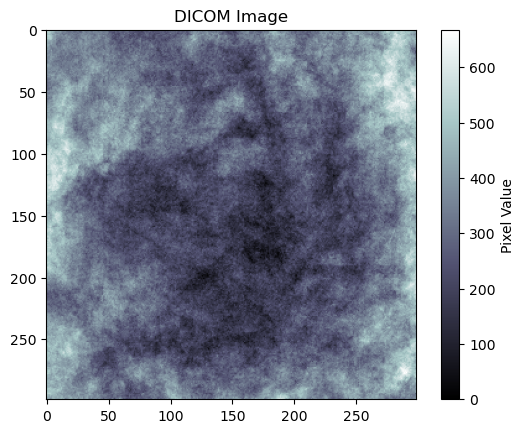

Photometric Interpretation: MONOCHROME2


In [183]:
# Load DICOM file
orig_dicom = get_dicom(r"C:\Users\jssuz\OneDrive\Desktop\grad_school_files\capstone\Dataset_B_Full\output_cropped_converted_monochrome2\0de15bbc9f84e965d634e2bc686d11f1.dicom")
plt.imshow(orig_dicom.pixel_array, cmap=plt.cm.bone)
plt.title("DICOM Image")
plt.colorbar(label="Pixel Value")
plt.show()

# Access and print the Photometric Interpretation


In [184]:
print(orig_dicom.pixel_array[:10, :10])

[[560 539 497 513 519 511 518 494 446 440]
 [545 559 528 512 494 498 498 450 441 423]
 [521 518 531 504 468 471 426 373 371 399]
 [494 503 516 482 447 433 427 389 378 360]
 [529 482 493 470 467 394 394 428 397 399]
 [527 529 529 501 481 450 405 415 365 355]
 [534 497 514 517 497 440 402 395 368 370]
 [482 515 508 517 502 436 397 416 375 340]
 [473 461 475 497 473 398 410 419 325 357]
 [505 443 438 423 416 415 370 393 360 333]]


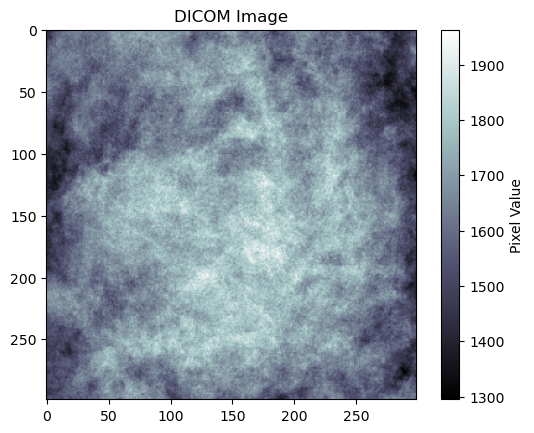

Photometric Interpretation: MONOCHROME2


In [185]:
## Check to see if the images were successfully converted. 
# Load DICOM file
inverted_dicom = get_dicom(r"C:\Users\jssuz\OneDrive\Desktop\grad_school_files\capstone\Dataset_B_Full\output_cropped_monochrome2\0de15bbc9f84e965d634e2bc686d11f1.dicom")
plt.imshow(inverted_dicom.pixel_array, cmap=plt.cm.bone)
plt.title("DICOM Image")
plt.colorbar(label="Pixel Value")
plt.show()

# Access and print the Photometric Interpretation
print("Photometric Interpretation:", inverted_dicom.PhotometricInterpretation)

## For whatever, inverting these values is just really really hard. 

In [186]:
print(inverted_dicom.pixel_array[:10, :10])

[[1403 1424 1466 1450 1444 1452 1445 1469 1517 1523]
 [1418 1404 1435 1451 1469 1465 1465 1513 1522 1540]
 [1442 1445 1432 1459 1495 1492 1537 1590 1592 1564]
 [1469 1460 1447 1481 1516 1530 1536 1574 1585 1603]
 [1434 1481 1470 1493 1496 1569 1569 1535 1566 1564]
 [1436 1434 1434 1462 1482 1513 1558 1548 1598 1608]
 [1429 1466 1449 1446 1466 1523 1561 1568 1595 1593]
 [1481 1448 1455 1446 1461 1527 1566 1547 1588 1623]
 [1490 1502 1488 1466 1490 1565 1553 1544 1638 1606]
 [1458 1520 1525 1540 1547 1548 1593 1570 1603 1630]]


**Check to see if duplicates are unique**

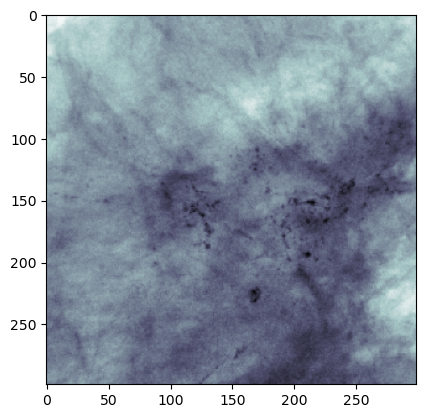

In [86]:
plt.imshow(get_dicom(r"C:\Users\jssuz\OneDrive\Desktop\grad_school_files\capstone\Dataset_B_Full\output_cropped_converted_monochrome2\duplicate_half1\0cf9cd3d36a7bfb95e66c0ba482eb8c0.dicom").pixel_array, cmap=plt.cm.bone)

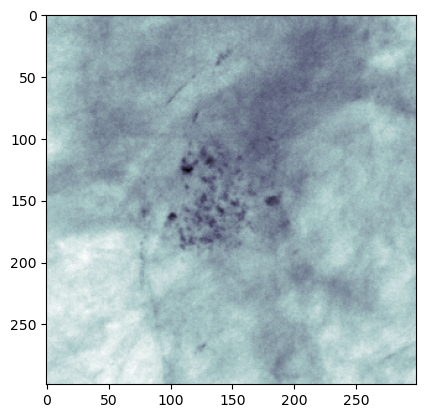

In [87]:
plt.imshow(get_dicom(r"C:\Users\jssuz\OneDrive\Desktop\grad_school_files\capstone\Dataset_B_Full\output_cropped_converted_monochrome2\duplicate_half2\0cf9cd3d36a7bfb95e66c0ba482eb8c0.dicom").pixel_array, cmap=plt.cm.bone)